<a href="https://colab.research.google.com/github/ElaYJ/Study_Deep_Learning/blob/main/Lecture/13_TFKeras_TL_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이 학습과 미세 조정 Fine Tuning

- 사전 학습된 모델(pretrained model)이 획득한 지식이 "전이(transferred)"되므로 전이 학습(transfer learning) 이라는 용어를 사용한다.

- 미세 조정(fine-tuning)은 모델이 사전 학습된 후에 수행되는 학습이다.

- 미세 조정(fine-tuning)을 수행하려면 먼저 사전 학습된 모델(pretrained model)을 확보한 다음,

	특정 태스크에 맞는 데이터셋(dataset)을 사용하여 추가 학습을 수행하게 된다.



<br></br>

## 예제. cats_vs_dogs

- TensorFlow Keras Lib

- 학습 코드는 텐서플로우 공식 페이지의 코드이다.

	코드가 간결하게 잘 작성되어 있어 그대로 사용한다.

- 참고: https://www.tensorflow.org/guide/keras/transfer_learning?hl=ko

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import tensorflow_datasets as tfds

# tfds를 통해 데이터를 가져올 준비
tfds.disable_progress_bar()

(train_ds, validation_ds, test_ds), metadata = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True, # metadata
    as_supervised=True, # Include labels
)
#--> as_supervised옵션이 True이면 데이터가 라벨과 함께 tuple 형태로 저장된다.

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 18610
Number of validation samples: 2326
Number of test samples: 2326


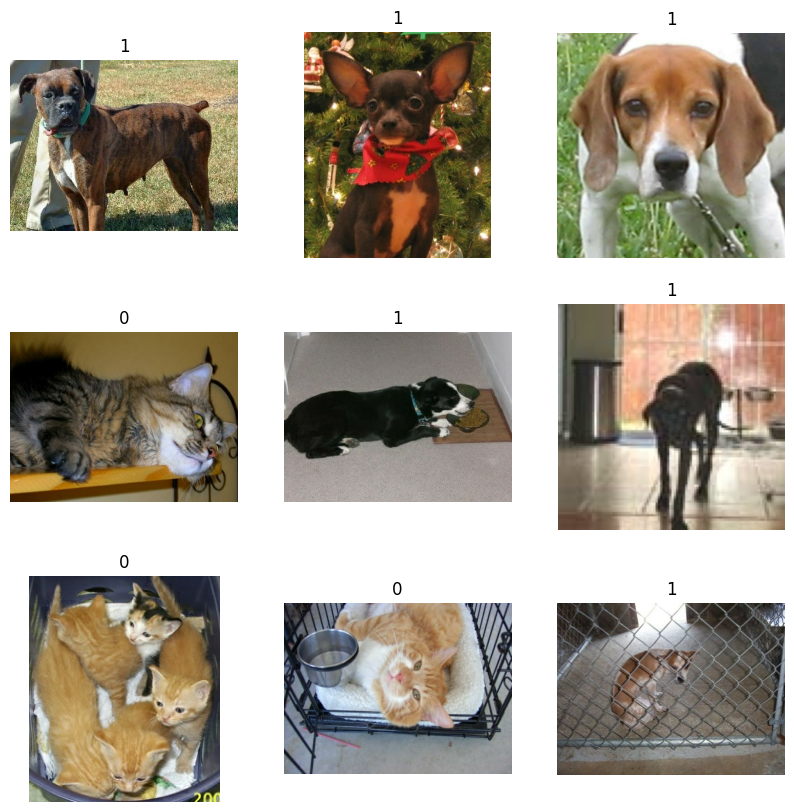

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    # plt.title(int(label))
    plt.title(label.numpy())
    plt.axis("off")

In [4]:
metadata

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpn2zlmckbtfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    

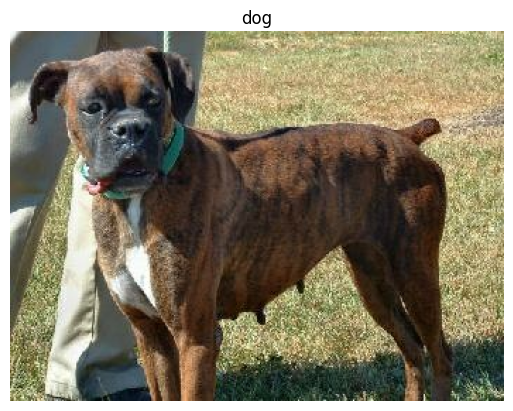

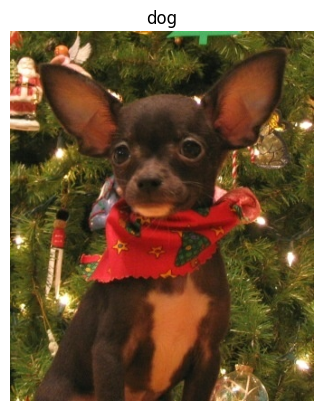

In [5]:
# 메타 정보에서 라벨 이름 가져와 2개만 확인

get_label_name = metadata.features['label'].int2str

for img, label in train_ds.take(2):
    plt.figure()
    plt.imshow(img)
    plt.title(get_label_name(label))
    plt.axis("off")

In [6]:
IMG_SIZE = 160 #--> 모든 이미지를 160 x 160

# 이미지 전처리 함수
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1 # 0~225 --> 0~2 --> -1~1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [7]:
# map() 함수를 이용해 빠르게 적용 가능하다.
# 큰 용량일 때 map() 함수가 유리하다.

train = train_ds.map(format_example)
valid = validation_ds.map(format_example)
test = test_ds.map(format_example)

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# batch size 적용하고 shuffle
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_batches = valid.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# 확인
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

</br>

### __`base_model.trainable=False`__

#### - 모델

- 이 모델은 1.4M 이미지와 1000개의 클래스로 구성된 대규모 데이터셋인 ImageNet 데이터셋을 사용해 사전 훈련된(pretrained) 모델이다.

- 먼저 기능 추출을 사용할 MobileNet V2 층을 선택한다.

- flatten 연산을 하기 전에 맨 아래 층을 가지고 진행한다. (병목층)

- include_top = False 로 지정하면 맨 위에 분류 층이 포함되지 않은 네트워크를 로드하므로 특징 추출에 이상적이다.

In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# MobileNet V2 모델
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet'
)
#--> include_top은 출력단을 의미하고 False 설정은 빼고 가져온다는 의미이다.

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# 특징 추출기는 각 160x160x3 이미지를 5x5x1280 개의 특징 블록으로 변환한다.

feature_batch = base_model(image_batch)
feature_batch.shape
#--> top(출력단)을 빼고 가져 왔으니 그 바로 이전 Layer의 shpae이 출력된다.

TensorShape([32, 5, 5, 1280])

In [11]:
# 모델 확인하기

base_model.trainable = False
base_model.summary() # Trainable params: 0 --> 여기까지는 가중치를 건드리지 않겠다는 의미이다.

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

#### - Global Average Pooling Layer

- GlobalAveragePooling2D 층을 사용하여 특징을 이미지 한 개당 1280개의 요소 벡터로 변환한다.

    - 채널마다의 평균값을 뽑아내는 층이다.

    <img src="https://github.com/ElaYJ/supplement/assets/153154981/d6f08ab0-c291-476a-b43a-38e5420c0500" width="97%">


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
#--> 한 채널(5x5)의 평균값만 뽑아놓은 것이다.

(32, 1280)


In [13]:
# Dense 층을 사용하여 특징을 이미지당 단일 예측 수행

prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [14]:
prediction_batch #--> 양수는 클래스 1을 예측하고 음수는 클래스 0을 예측한 것이다.

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-0.0330715 ],
       [ 0.2930199 ],
       [-0.8531316 ],
       [-1.3147526 ],
       [-0.5007861 ],
       [-0.3794747 ],
       [ 0.48276353],
       [-0.05940317],
       [-1.6438609 ],
       [-0.06709021],
       [-0.47642544],
       [-0.75224596],
       [-1.2102939 ],
       [-1.806282  ],
       [-1.3151053 ],
       [-1.4905038 ],
       [-0.10342266],
       [ 0.36884856],
       [-0.20606646],
       [-0.15735354],
       [ 0.16996282],
       [-1.3281114 ],
       [-1.0939677 ],
       [-0.36524165],
       [-0.10599288],
       [-1.5735819 ],
       [-1.421193  ],
       [-0.6541349 ],
       [ 0.32785589],
       [-0.75396085],
       [-0.2498798 ],
       [-0.53319526]], dtype=float32)>

In [15]:
# 전체 모델 구성

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer #--> Dense(1)개를 뽑아내는 Output Layer
])

In [16]:
# 모델 컴파일

base_learning_rate = 0.0001
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate), #'rmsprop',
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [17]:
# 아무 학습을 하지 않은 현재의 성능은??

initial_epochs = 10
validation_step = 20

loss0, accuracy0 = model.evaluate(valid_batches, steps=validation_step)

20/20 [==============================] - 4s 43ms/step - loss: 0.7157 - accuracy: 0.5250


In [18]:
# 학습

history = model.fit(train_batches, epochs=initial_epochs, validation_data=valid_batches)
#--> trainable weights가 1200여개뿐이지만 연산은 전체를 다해야 하기 때문에 만만한 시간은 아니다.
#--> 그러나 mobilenet 전체를 다시 학습하는 것 보다는 훨씬 좋다.

Epoch 1/10
582/582 [==============================] - 41s 61ms/step - loss: 0.2079 - accuracy: 0.9072 - val_loss: 0.0910 - val_accuracy: 0.9673
Epoch 2/10
582/582 [==============================] - 36s 59ms/step - loss: 0.0743 - accuracy: 0.9736 - val_loss: 0.0659 - val_accuracy: 0.9742
Epoch 3/10
582/582 [==============================] - 35s 57ms/step - loss: 0.0596 - accuracy: 0.9779 - val_loss: 0.0575 - val_accuracy: 0.9807
Epoch 4/10
582/582 [==============================] - 37s 60ms/step - loss: 0.0534 - accuracy: 0.9802 - val_loss: 0.0535 - val_accuracy: 0.9819
Epoch 5/10
582/582 [==============================] - 34s 57ms/step - loss: 0.0497 - accuracy: 0.9820 - val_loss: 0.0512 - val_accuracy: 0.9841
Epoch 6/10
582/582 [==============================] - 36s 59ms/step - loss: 0.0472 - accuracy: 0.9826 - val_loss: 0.0493 - val_accuracy: 0.9837
Epoch 7/10
582/582 [==============================] - 36s 59ms/step - loss: 0.0454 - accuracy: 0.9834 - val_loss: 0.0484 - val_accuracy:

In [19]:
history.history

{'loss': [0.2079489678144455,
  0.07434611767530441,
  0.05956711992621422,
  0.05336994305253029,
  0.04967963695526123,
  0.047241587191820145,
  0.0454007126390934,
  0.044114433228969574,
  0.04298203065991402,
  0.04196082055568695],
 'accuracy': [0.9072004556655884,
  0.973616361618042,
  0.9779151082038879,
  0.9801719784736633,
  0.9819989204406738,
  0.982643723487854,
  0.9834497570991516,
  0.9842557907104492,
  0.9844707250595093,
  0.984846830368042],
 'val_loss': [0.09096313267946243,
  0.0658903568983078,
  0.05746426433324814,
  0.053519364446401596,
  0.05122656747698784,
  0.04930057376623154,
  0.04841111972928047,
  0.047474075108766556,
  0.04669203236699104,
  0.04630912095308304],
 'val_accuracy': [0.9673258662223816,
  0.9742046594619751,
  0.9806534647941589,
  0.9819432497024536,
  0.9840928912162781,
  0.9836629629135132,
  0.9845227599143982,
  0.9840928912162781,
  0.9840928912162781,
  0.9836629629135132]}

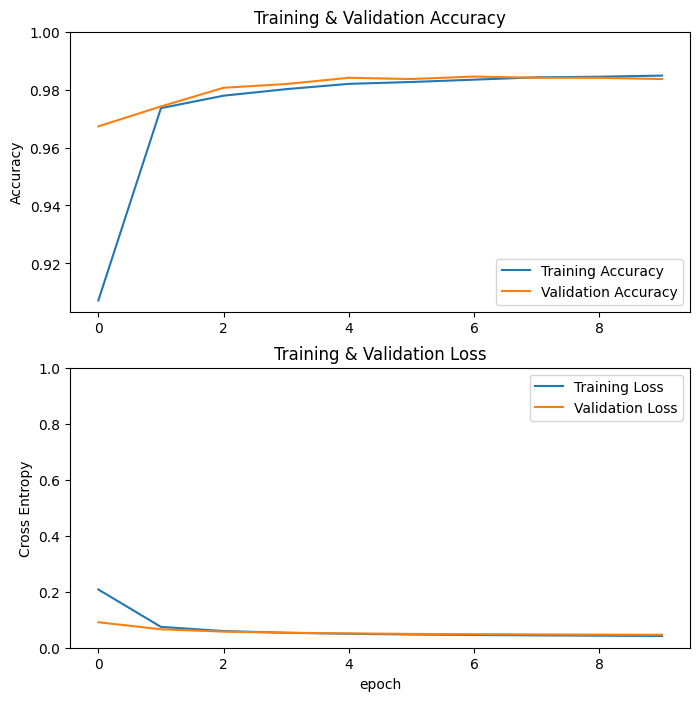

In [20]:
# 성능 확인

acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training & Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training & Validation Loss')
plt.show()

</br>

### __`base_model.trainable=True`__

In [21]:
# 일단 모두 trainable하게 변경한다.

base_model.trainable = True
print("Number of layers in the base model:", len(base_model.layers))

Number of layers in the base model: 154


In [22]:
# 100번 째부터 튜닝이 가능하게 설정한다.
# 이미지를 미세하게 보는 filter가 적용되는 부분은 고정하고,
# 이미지의 전체적으로 보는(숲을 보는) filter가 적용되는 layer 부분을 재학습한다.
# 'fine_tune_at' 층 이전의 모든 층을 고정한다.

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [23]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), #--> 학습 비율을 낮춘다.
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [24]:
# 학습
# 총 20번의 epoch

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_batches, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=valid_batches
)
#--> 시작 epoch가 1이 아니다. 이전 10번의 epoch에 이어서 학습한다.

Epoch 10/20
582/582 [==============================] - 47s 65ms/step - loss: 0.1319 - accuracy: 0.9502 - val_loss: 0.0718 - val_accuracy: 0.9807
Epoch 11/20
582/582 [==============================] - 40s 66ms/step - loss: 0.0730 - accuracy: 0.9712 - val_loss: 0.0507 - val_accuracy: 0.9837
Epoch 12/20
582/582 [==============================] - 39s 65ms/step - loss: 0.0516 - accuracy: 0.9798 - val_loss: 0.0494 - val_accuracy: 0.9819
Epoch 13/20
582/582 [==============================] - 40s 66ms/step - loss: 0.0410 - accuracy: 0.9834 - val_loss: 0.0500 - val_accuracy: 0.9815
Epoch 14/20
582/582 [==============================] - 38s 63ms/step - loss: 0.0316 - accuracy: 0.9889 - val_loss: 0.0483 - val_accuracy: 0.9824
Epoch 15/20
582/582 [==============================] - 38s 64ms/step - loss: 0.0242 - accuracy: 0.9907 - val_loss: 0.0489 - val_accuracy: 0.9837
Epoch 16/20
582/582 [==============================] - 40s 67ms/step - loss: 0.0216 - accuracy: 0.9923 - val_loss: 0.0479 - val_ac

In [26]:
history_fine.history

{'loss': [0.13187618553638458,
  0.07296714931726456,
  0.051602330058813095,
  0.04100818559527397,
  0.031581733375787735,
  0.024176357313990593,
  0.02164411172270775,
  0.013708917424082756,
  0.012095796875655651,
  0.011749861761927605,
  0.007739183958619833],
 'accuracy': [0.9501881003379822,
  0.9711982607841492,
  0.9798495173454285,
  0.9834497570991516,
  0.9889307022094727,
  0.9906501770019531,
  0.992315948009491,
  0.9954325556755066,
  0.9955400228500366,
  0.995593786239624,
  0.9975281953811646],
 'val_loss': [0.07184097170829773,
  0.05066294968128204,
  0.04937267675995827,
  0.04995926097035408,
  0.048256635665893555,
  0.048901766538619995,
  0.047883931547403336,
  0.0513942651450634,
  0.052763067185878754,
  0.05195508524775505,
  0.05237770825624466],
 'val_accuracy': [0.9806534647941589,
  0.9836629629135132,
  0.9819432497024536,
  0.9815133213996887,
  0.9823731780052185,
  0.9836629629135132,
  0.9840928912162781,
  0.9823731780052185,
  0.9836629629135

In [28]:
# 최초 history에 방금 학습한 결과를 추가한다.

acc += history_fine.history['accuracy']
valid_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
valid_loss += history_fine.history['val_loss']

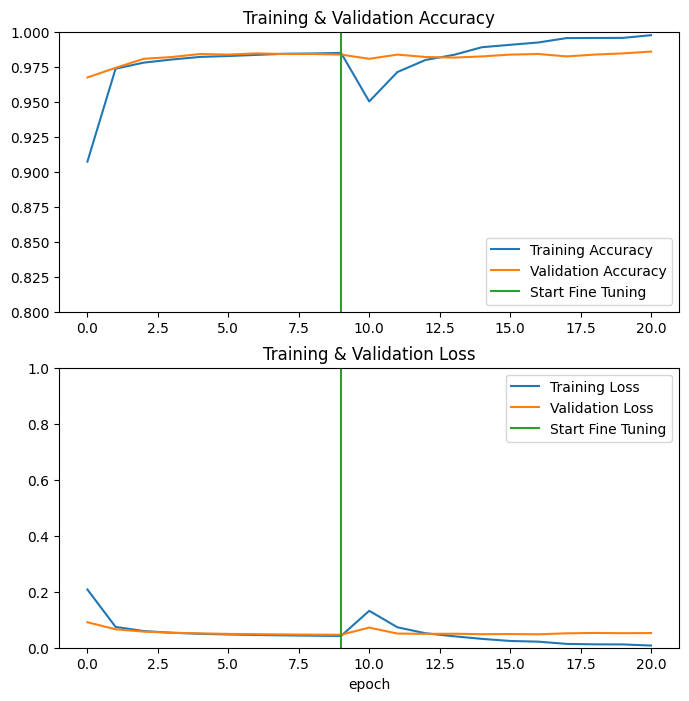

In [29]:
# 그래프

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.ylim([0.8,1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.title('Training & Validation Loss')
plt.show()

<br></br>

## 예제. ImageNet Classification

- 사전 훈련된 분류기 모델을 사용하여 이미지를 얻고 이미지가 무엇인지 예측한다.

- 텐서플로 허브(tensorflow_hub) MobileNet V2 모델 사용

- MobileNet V2는 이미지 처리 작업에 효과적으로 사용될 수 있는 사전 훈련된 모델이다.

- tensorflow_hub와 tensorflow 모듈을 가져온 후, hub.KerasLayer() 함수를 사용하여 MobileNet을 로드할 수 있다.

- trainable=False(default)로 설정하여 사전 훈련된 모델의 가중치가 업데이트되지 않도록 한다.

- 그런 다음, 입력 이미지를 받기 위한 새로운 입력 레이어를 만든다.

- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=ko

In [3]:
import time
import datetime

In [ ]:
# !pip install -U tf-hub-nightly

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

%load_ext tensorboard

In [11]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [34]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
Total params: 3540265 (13.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [35]:
# 텐서플로 허브에서 mobilenet 가져오기

IMAGE_SHAPE = (224, 224)
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

mobilenet = hub.KerasLayer(url, input_shape=IMAGE_SHAPE+(3,)) # input_shape=(224, 224, 3)

classifier = tf.keras.Sequential([mobilenet])
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              3540265   
                                                                 
Total params: 3540265 (13.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


61306/61306 [==============================] - 0s 0us/step


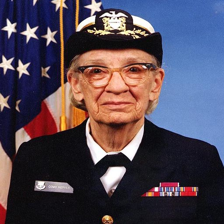

In [12]:
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

# 이미지 하나 가져오기
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'
grace_hopper = tf.keras.utils.get_file('image.jpg', url)
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [37]:
# 이미지 정규화

grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [38]:
# 배치 차원을 추가하고 이미지를 모델로 전달해 예측해본다.

result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 2s 2s/step


(1, 1001)

In [39]:
# 예측 결과는 이미지에 대한 각 클래스의 확률을 계산하는 로짓의 1001 요소 벡터이다.
# 그래서 최상위 클래스 ID는 argmax로 확인할 수 있다.
# argmax로 index 찾기

predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class #--> 653번 class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [23]:
# label을 받아서 예측 디코딩
# 예측 클래스 ID를 취하고 ImageNet 레이블을 가져와서 예측을 디코딩한다.

url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', url)
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


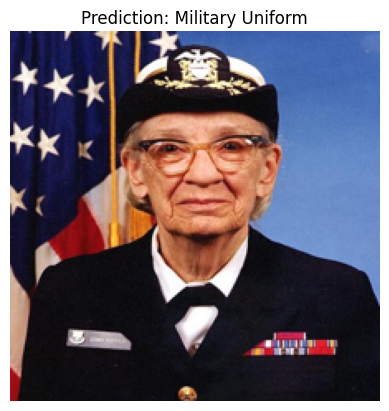

In [41]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

</br>

### - 전이 학습

- 이 예제를 위해 TensorFlow의 꽃 데이터세트를 사용한다.

- 꽃 이름 예측하기

In [5]:
# flower dataset 가져오기

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

data_file = tf.keras.utils.get_file('flower_photos.tgz', url, cache_dir='.', extract=True, untar=True)

228813984/228813984 [==============================] - 1s 0us/step


In [6]:
data_file

'./datasets/flower_photos.tgz'

In [7]:
import pathlib

data_root = pathlib.Path(data_file).with_suffix('')
data_root

PosixPath('datasets/flower_photos')

In [43]:
# rescale 및 라벨 인식

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [13]:
# 이미지 데이터셋 생성

batch_size = 32

# subset="training"으로 설정하여 훈련 데이터셋을 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size
)

# subset="validation"으로 설정하여 검증 데이터셋을 생성
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SHAPE, #--> (img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
# 훈련 데이터셋에서 첫 번째 배치 가져오기
for images, labels in train_ds.take(1):
    print(images.shape)  # 이미지 shape 출력
    print(labels.numpy())  # 레이블 값 출력

# 검증 데이터셋에서 첫 번째 배치 가져오기
for images, labels in valid_ds.take(1):
    print(images.shape)  # 이미지 shape 출력
    print(labels.numpy())  # 레이블 값 출력

(32, 224, 224, 3)
[2 1 4 3 1 2 1 2 4 1 4 4 3 4 1 2 0 4 1 1 1 4 3 2 3 1 4 2 2 3 4 3]
(32, 224, 224, 3)
[1 0 3 2 4 2 3 1 2 4 4 1 1 1 3 3 0 4 1 2 0 3 4 1 4 4 0 1 2 3 1 3]


In [15]:
# 꽃 데이터세트에는 다섯 개의 클래스가 있다.

class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [16]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [17]:
# Rescale
# 이미지 모델에 대한 TensorFlow Hub의 규칙은 [0, 1] 범위의 부동 입력을 예상하는 것이다.
# 이를 위해 Rescaling 레이어를 사용한다.

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [18]:
# 버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 한다.
# AUTOTUNE은 데이터를 로드할 때 사용해야 하는 가장 중요한 tf.data 메서드 중 일부이다.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

- 이미지 배치 한 세트에 대한 예측 결과 확인

- 이미지 배치에 대한 분류기를 실행해본다.

In [19]:
# image_batch 생성

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [20]:
image_batch

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[3.45938414e-01, 4.87114877e-01, 7.85154104e-01],
         [3.49019617e-01, 4.90196109e-01, 7.88235366e-01],
         [3.46149713e-01, 4.87398744e-01, 7.84841478e-01],
         ...,
         [9.31481719e-01, 4.18626428e-01, 1.86790731e-02],
         [9.34386313e-01, 4.12958920e-01, 2.51200870e-02],
         [9.31017280e-01, 3.97278607e-01, 6.58321427e-03]],

        [[3.49854976e-01, 4.91031438e-01, 7.89070666e-01],
         [3.51521879e-01, 4.92698371e-01, 7.90737629e-01],
         [3.56593907e-01, 5.01159251e-01, 7.96943784e-01],
         ...,
         [7.74180889e-01, 3.07648361e-01, 2.30455883e-02],
         [7.34022141e-01, 2.91095138e-01, 4.62556956e-03],
         [6.67004824e-01, 2.79489279e-01, 9.57409386e-03]],

        [[3.61099452e-01, 5.07352948e-01, 8.02853763e-01],
         [3.58907312e-01, 5.05160868e-01, 8.00661564e-01],
         [3.67163152e-01, 5.16182780e-01, 8.09740186e-01],
         ...,
         [

In [21]:
# 예측

result_batch = classifier.predict(image_batch)
result_batch.shape

1/1 [==============================] - 2s 2s/step


(32, 1001)

In [24]:
# 예측된 라벨 확인

predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'buckeye', 'sunscreen', 'guillotine', 'porcupine', 'vase',
       'picket fence', 'daisy', 'daisy', 'worm fence', 'daisy', 'bee',
       'plastic bag', 'daisy', 'coral fungus', 'damselfly', 'bee',
       'daisy', 'cardoon', 'daisy', 'barn spider', 'corn',
       'Bedlington terrier', 'lotion', 'sea urchin', 'daisy', 'vase',
       'daisy', 'orange', 'picket fence', 'poncho', 'daisy'], dtype='<U30')

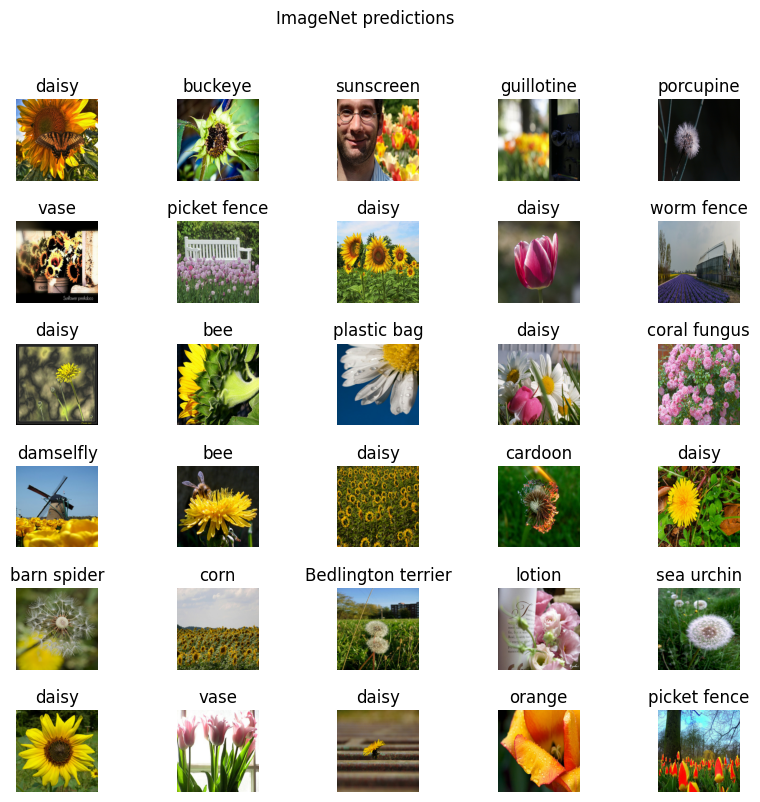

In [25]:
# 얼마나 많은 예측들이 이미지에 맞는지 확인

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")
#--> 모델이 ("daisy"를 제외한) 모든 것을 대비해서 학습된 클래스가 아니라는 것을 고려하면 합리적이다.

</br>

### - Headless Model

- 텐서플로 허브는 맨 위 분류층이 없어도 모델을 분배 시킬 수 있다.

- 이는 전이 학습을 쉽게 할 수 있게 만든다.

- 선행 훈련된 모델을 hub.KerasLayer를 사용하고 Keras 레이어로 래핑하여 특성 추출기를 만든다.

- trainable=False 인수를 사용하여 변수를 고정하면 훈련하는 동안 새 분류자 레이어만 수정된다.

In [26]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [27]:
# 특징 추출기

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
) # feature_extractor_layer.trainable = False
#--> feature_extractor_layer는 각각의 이미지마다 길이가 1280인 벡터를 반환한다.

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [28]:
# 분류 Head 붙이기 : Dense Layer 추가
# tf.keras.Sequential 모델에 있는 허브 계층을 포장하고, 새로운 분류 계층을 추가한다.

num_classes = len(class_names)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [29]:
# 출력층

predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

### - compile

- 모델 학습시키기

- Model.compile을 사용하여 훈련 프로세스를 구성하고

- tf.keras.callbacks.TensorBoard 콜백을 추가하여 로그를 생성하고 저장한다.

In [30]:
# 컴파일

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [31]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir

'logs/fit/20240416-090827'

In [32]:
# callback 정의
# TensorBoard에서 훈련 진행 상황을 시각화하려면 TensorBoard 콜백을 생성하고 로그를 저장한다.

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
) # Enable histogram computation for every epoch.

In [33]:
# batch별 'loss'와 'accuracy'를 확인하기 위한 콜백 인스턴스

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self) -> None:
       super().__init__()
       self.batch_losses = []
       self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [34]:
# train_dataset의 요소(specification) 확인
# element_spec 속성은 데이터셋의 요소(specification)를 나타내는 튜플을 반환한다.
# 각 요소는 (image, label)와 같은 형태로 표시된다.
# 따라서 첫 번째 요소인 image는 이미지 데이터의 텐서 스펙(specification)을 나타내고,
# 두 번째 요소인 label은 레이블 데이터의 텐서 스펙(specification)을 나타낸다.
print(train_ds.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [35]:
# train_dataset의 전체 샘플 크기 확인
sample_size = tf.data.experimental.cardinality(train_ds).numpy()
print("Sample size:", sample_size)

Sample size: 92


In [36]:
# train_dataset의 배치 크기 확인
batch_size = train_ds.element_spec[0].shape[0]
print("Batch size:", batch_size)

Batch size: None


In [37]:
np.ceil(2936/32)

92.0

In [38]:
# 학습

steps_per_epoch = np.ceil(2936/32)
batch_stats_callback = CollectBatchStats()

history = model.fit(
    train_ds, epochs=2, steps_per_epoch=steps_per_epoch, callbacks=[batch_stats_callback]
)

Epoch 1/2
92/92 [==============================] - 117s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/2
92/92 [==============================] - 95s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00


In [39]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard()

# %tensorboard --logdir logs/fit

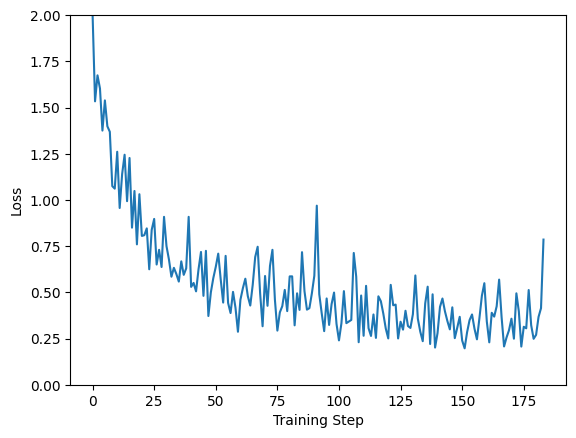

In [40]:
# Loss 확인

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Step")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.show()

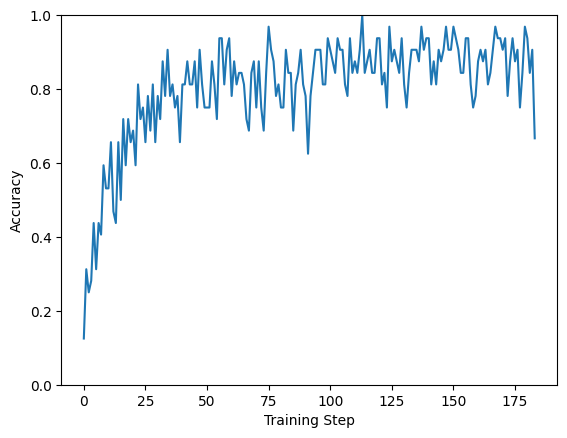

In [41]:
# Accuracy 확인

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Step")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

In [44]:
# 클래스 이름이 정렬된 리스트 생성

class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [45]:
# 예측

predicted_batch = model.predict(valid_ds)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

23/23 [==============================] - 28s 1s/step


In [46]:
# 검증 데이터셋에서 레이블 데이터만 분리하여 리스트에 저장

val_labels = []
for _, labels in valid_ds:
    val_labels.extend(labels.numpy())
print(val_labels[:32])

[0, 4, 2, 2, 4, 1, 4, 0, 1, 4, 1, 2, 0, 2, 4, 0, 0, 1, 3, 2, 2, 3, 2, 2, 4, 4, 1, 4, 4, 1, 2, 0]


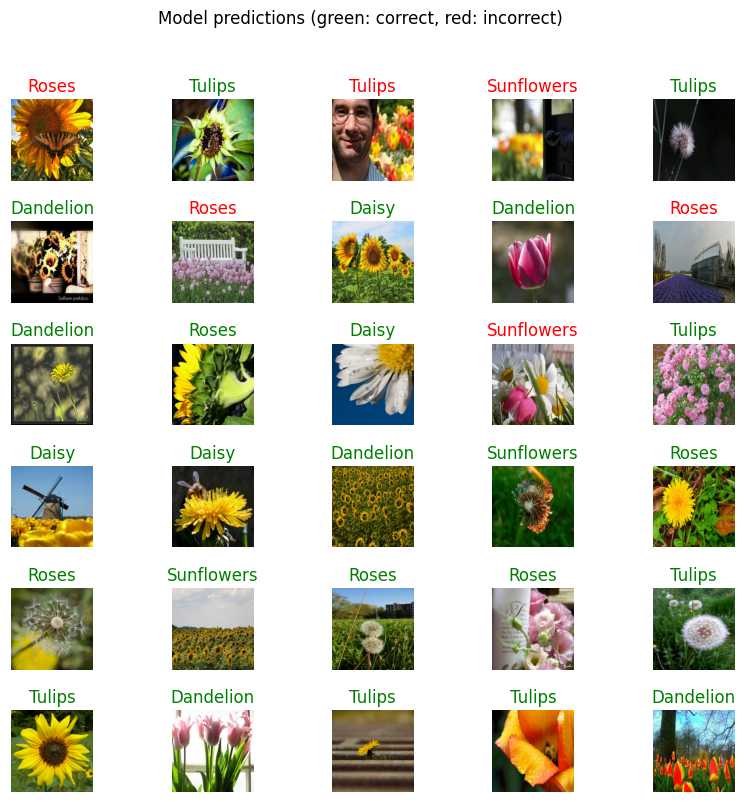

In [47]:
# 예측 정확도 확인

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == val_labels[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

</br>

### - model save

In [48]:
t = time.time()

export_path = "./saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

'./saved_models/1713258925'

In [49]:
# 모델 다시 읽어오기

reloaded_model = tf.keras.models.load_model(export_path)

In [50]:
# 예측

result_batch = model.predict(valid_ds)
reloaded_result_batch = reloaded_model.predict(valid_ds)

abs(reloaded_result_batch - result_batch).max()

23/23 [==============================] - 24s 1s/step


0.0

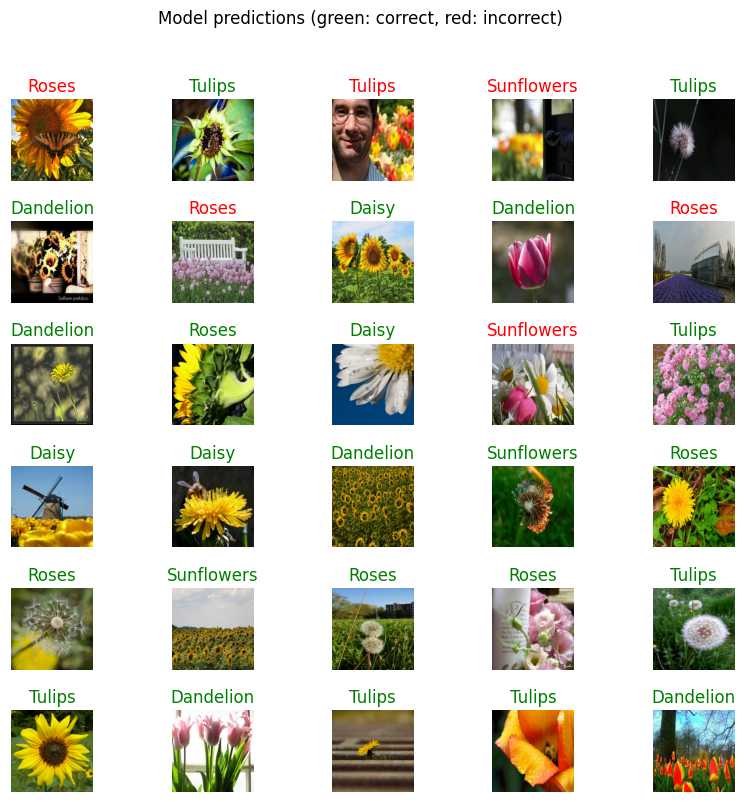

In [51]:
# 예측 정확도 확인

reloaded_predicted_id = np.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if reloaded_predicted_id[n] == val_labels[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")